# Semi-supervised Learning with FixMatch on UC Merced Land Use Dataset
In this notebook, we will simulate a semi-supervised learning scenario on the UC Merced Land Use Dataset. We will experiment with FixMatch method and report test set performance.

[FixMatch](https://arxiv.org/abs/2001.07685) is a popular semi-supervised learning method based on consistency regularization and pseudo-labeling. The main idea is to train a model on labeled and unlabeled data simultaneously. For labeled data, a supervised cross-entropy loss is optimized. For unlabeled data, a weak-augmented view and a strong-augmented view are generated for each image. The weak-augmented view is used to generate pseudo-labels for unlabeled data. The strong-augmented view is used to enforce consistency between the model predictions on the weak-augmented view and the strong-augmented view. 

[UC Merced Land Use Dataset]() is a popular high-resolution remote sensing dataset for land use scene classification. It contains 21 land use classes with 100 images per class.

In [1]:
#!pip install -U wandb
#import wandb
#wandb.login()

In [2]:
#run = wandb.init(project="waw2023-fixmatch",
#           config={
#               "method": "supervised & fixmatch",
#               "dataset": "UC Merced",
#           })

### Import modules

In [1]:
from datetime import datetime
from functools import partial
from PIL import Image
from torch.utils.data import Dataset,DataLoader#,Subset
from torchvision import transforms, models
import torchvision
from tqdm import tqdm
import argparse
import json
import math
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import kornia.augmentation as K
import copy

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
#!nvidia-smi -i 0

### Prepare UC Merced dataset

Download and extract the dataset

In [4]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip --output-document UCMerced_LandUse.zip

--2023-11-11 15:51:28--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: 'UCMerced_LandUse.zip'

100%[======================================>] 332,468,434 15.3MB/s   in 27s    

2023-11-11 15:51:55 (11.9 MB/s) - 'UCMerced_LandUse.zip' saved [332468434/332468434]



In [5]:
with zipfile.ZipFile('UCMerced_LandUse.zip', 'r') as zip_ref:
    zip_ref.extractall('UCMerced_LandUse')

Split into train/test sets

In [6]:
#!pip install split-folders
import splitfolders
splitfolders.ratio('UCMerced_LandUse/UCMerced_LandUse/Images', output="UCMerced_LandUse/UCMerced_LandUse_train_test", seed=42, ratio=(.8, 0,0.2)) # 1680 train, 420 test

Copying files: 2100 files [00:03, 639.20 files/s]


### Define hyperparameters

In [2]:
batch_size = 32
mu = 7 # multiplier for unlabeled data: batch_size_unlabeled = batch_size*mu
temperature = 0.9 # temperature for sharpening
lambda_u = 1 # weight of unlabeled loss
blr = 0.03 # base learning rate
epochs = 400

logs = {'epoch1':[], 'sup_train_acc':[], 'sup_test_acc':[],
        'epoch2':[], 'fixmatch_train_acc':[], 'fixmatch_test_acc':[]}

### Dataset and DataLoader
We split the training set into 10% labeled and 90% unlabeled data. We use the labeled data to train the model with supervised cross-entropy loss, and the unlabeled data to train the model with consistency regularization and pseudo-labeling.

In [3]:
class Subset(Dataset):

    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):

        data, label = self.dataset[self.indices[idx]]
        if self.transform:
            return self.transform(data), label
        else:
            return data, label

    def __len__(self):
        return len(self.indices)

    def __getattr__(self, name):
        return getattr(self.dataset, name)

# resize to 112x112 for compute efficiency
base_transform = transforms.Compose([
    transforms.Resize((112,112)),
    ])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(112,scale=(0.6,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    #transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])

test_transform = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.ToTensor(),
    #transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])

unlabel_transform_s = K.AugmentationSequential(K.auto.RandAugment(n=2, m=10),
                                               #K.Normalize(torch.tensor([0.4914, 0.4822, 0.4465]),torch.tensor([0.2023, 0.1994, 0.2010]))
                                               )
unlabel_transform_w = K.AugmentationSequential(
            K.RandomResizedCrop((112,112),scale=(0.6,1.0)),
            K.RandomHorizontalFlip(p=0.5),
            #K.Normalize(torch.tensor([0.4914, 0.4822, 0.4465]),torch.tensor([0.2023, 0.1994, 0.2010]))
        )


# Load data
#train_dataset_all = torchvision.datasets.ImageFolder(root='EuroSAT/EuroSAT_RGB_train_test/train')
#train_dataset_all = torchvision.datasets.CIFAR10('./', train=True, download=False)
train_dataset_all = torchvision.datasets.ImageFolder(root='UCMerced_LandUse/UCMerced_LandUse_train_test/train')

indices = np.arange(len(train_dataset_all))
train_indices_labeled, train_indices_unlabeled = train_test_split(indices,train_size=0.1,stratify=train_dataset_all.targets,random_state=42)
train_dataset_labeled = Subset(train_dataset_all,train_indices_labeled,transform=train_transform)
train_dataset_unlabeled = Subset(train_dataset_all,train_indices_unlabeled,transform=test_transform)
#test_dataset = torchvision.datasets.ImageFolder(root='EuroSAT/EuroSAT_RGB_train_test/test',transform=test_transform)
#test_dataset = torchvision.datasets.CIFAR10('./', train=False, download=False, transform=test_transform)
test_dataset = torchvision.datasets.ImageFolder(root='UCMerced_LandUse/UCMerced_LandUse_train_test/test',transform=test_transform)

train_loader_labeled = DataLoader(train_dataset_labeled, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
train_loader_unlabeled = DataLoader(train_dataset_unlabeled, batch_size=batch_size*mu, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=False)

# Print out the sizes of each dataset part
print(f"Size of labeled training dataset: {len(train_dataset_labeled)}")
print(f"Size of unlabeled training dataset: {len(train_dataset_unlabeled)}")
print(f"Size of test dataset: {len(test_dataset)}")

Size of labeled training dataset: 168
Size of unlabeled training dataset: 1512
Size of test dataset: 420


### Define supervised training and testing

In [4]:
# lr scheduler for training
def adjust_learning_rate(optimizer, epoch):
    """Decay the learning rate based on schedule"""
    lr = blr
    lr *= 0.5 * (1. + math.cos(math.pi * epoch / epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# train for one epoch
def train_sup(net, data_loader, train_optimizer, epoch):
    net.train()
    adjust_learning_rate(train_optimizer, epoch)

    total_acc, total_loss, total_num, train_bar = 0.0, 0.0, 0, tqdm(data_loader)
    for img,target in train_bar:
        img, target = img.to(device), target.to(device)

        out = net(img)
        loss = criterion(out,target.long())

        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += data_loader.batch_size
        total_loss += loss.item() * data_loader.batch_size

        score = torch.sigmoid(out).detach().cpu()
        pred_labels = torch.argmax(score,axis=1)
        average_precision = (pred_labels == target.cpu()).float().sum().item()

        total_acc += average_precision

        train_bar.set_description('Train Epoch: [{}/{}], lr: {:.6f}, Loss: {:.4f}, Acc: {:.4f}'.format(epoch, epochs, optimizer.param_groups[0]['lr'], total_loss / total_num, total_acc / total_num))

    return total_loss / total_num, total_acc / total_num


# test
def test(net, test_data_loader, epoch):
    net.eval()
    with torch.no_grad():
        test_bar = tqdm(test_data_loader)
        total_top1 = 0
        total_num = 0
        for img, target in test_bar:
            img, target = img.to(device), target.to(device)

            out = net(img)

            score = torch.sigmoid(out).detach().cpu()
            pred_labels = torch.argmax(score,axis=1)
            total_num += img.size(0)
            total_top1 += (pred_labels == target.cpu()).float().sum().item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}%'.format(epoch, epochs, total_top1 / total_num * 100))

    return total_top1 / total_num * 100

### Baseline: supervised training from scratch with labeled data

In [5]:
model = torchvision.models.resnet18()
model.fc = nn.Linear(512,21)
model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=blr, momentum=0.9, weight_decay=0.0005)

for epoch in range(0, epochs+1):
    train_loss,train_acc = train_sup(model, train_loader_labeled, optimizer, epoch)
    #wandb.log({'epoch':epoch, 'sup_train_loss':train_loss, 'sup_train_acc':train_acc})
    if epoch%5 == 0:
        test_acc = test(model, test_loader, epoch)
        #wandb.log({'sup_test_acc':test_acc})
        logs['epoch1'].append(epoch)
        logs['sup_train_acc'].append(train_acc*100)
        logs['sup_test_acc'].append(test_acc)

Train Epoch: [0/400], lr: 0.030000, Loss: 3.1476, Acc: 0.0500: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]
Test Epoch: [0/400] Acc@1:5.24%: 100%|██████████| 14/14 [00:00<00:00, 30.33it/s]
Train Epoch: [1/400], lr: 0.030000, Loss: 3.0918, Acc: 0.1437: 100%|██████████| 5/5 [00:00<00:00, 14.66it/s]
Train Epoch: [2/400], lr: 0.029998, Loss: 2.9195, Acc: 0.1688: 100%|██████████| 5/5 [00:00<00:00, 14.36it/s]
Train Epoch: [3/400], lr: 0.029996, Loss: 2.6242, Acc: 0.2687: 100%|██████████| 5/5 [00:00<00:00, 14.32it/s]
Train Epoch: [4/400], lr: 0.029993, Loss: 2.3938, Acc: 0.3250: 100%|██████████| 5/5 [00:00<00:00, 14.35it/s]
Train Epoch: [5/400], lr: 0.029988, Loss: 2.3987, Acc: 0.3125: 100%|██████████| 5/5 [00:00<00:00, 14.40it/s]
Test Epoch: [5/400] Acc@1:8.10%: 100%|██████████| 14/14 [00:00<00:00, 31.51it/s]
Train Epoch: [6/400], lr: 0.029983, Loss: 2.1748, Acc: 0.3438: 100%|██████████| 5/5 [00:00<00:00, 14.39it/s]
Train Epoch: [7/400], lr: 0.029977, Loss: 1.8706, Acc: 0.4000: 100%|███████

### Define FixMatch training

In [6]:
def interleave(x, size):
    # function for interleave: rearranges a batch of data in an alternating pattern, i.e. [x1,x2,x3,x4] -> [x1,x3,x2,x4]
    # This serves as a regularizer
    # x: batch_size*(2*mu+1), 3, 112, 112
    # size: 2*mu+1
    # return: (batch_size*(2*mu+1), 3, 112, 112)
    s = list(x.shape)
    return x.reshape([-1, size] + s[1:]).transpose(0, 1).reshape([-1] + s[1:])

def de_interleave(x, size):
    # arrange the data back to the original order
    s = list(x.shape)
    return x.reshape([size, -1] + s[1:]).transpose(0, 1).reshape([-1] + s[1:])

def train_fixmatch(net, labeled_trainloader, unlabeled_trainloader, train_optimizer, epoch):
    net.train()
    adjust_learning_rate(train_optimizer, epoch)

    # build iterator for labeled and unlabeled dataset
    labeled_iter = iter(labeled_trainloader)
    unlabeled_iter = iter(unlabeled_trainloader)

    total_acc, total_loss, total_num, train_bar = 0.0, 0.0, 0, tqdm(range(len(labeled_trainloader)))

    for batch_idx in train_bar:

        inputs_x, targets_x = next(labeled_iter) #.next()
        inputs_u,  _ = next(unlabeled_iter) #.next()
        
        inputs_u_s = unlabel_transform_s(inputs_u)
        inputs_u_w = unlabel_transform_w(inputs_u)

        inputs = interleave(torch.cat((inputs_x, inputs_u_w, inputs_u_s)), 2*mu+1).to(device)
        targets_x = targets_x.to(device)
        logits = net(inputs)
        logits = de_interleave(logits, 2*mu+1)
        logits_x = logits[:batch_size]
        logits_u_w, logits_u_s = logits[batch_size:].chunk(2)
        del logits

        # supervised loss
        Lx = F.cross_entropy(logits_x, targets_x, reduction='mean')

        pseudo_label = torch.softmax(logits_u_w.detach()/temperature, dim=-1)
        max_probs, targets_u = torch.max(pseudo_label, dim=-1)
        mask = max_probs.ge(0.95).float() # mask is 1 if the max prob is greater or equal to 0.95

        # consistency loss
        Lu = (F.cross_entropy(logits_u_s, targets_u, reduction='none') * mask).mean()

        loss = Lx + lambda_u * Lu

        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += batch_size
        total_loss += loss.item() * batch_size

        score = torch.sigmoid(logits_x).detach().cpu()
        pred_labels = torch.argmax(score,axis=1)
        average_precision = (pred_labels == targets_x.cpu()).float().sum().item()

        total_acc += average_precision

        train_bar.set_description('Train Epoch: [{}/{}], lr: {:.6f}, Loss: {:.4f}, Acc: {:.4f}'.format(epoch, epochs, optimizer.param_groups[0]['lr'], total_loss / total_num, total_acc / total_num))

    return total_loss / total_num, total_acc / total_num

### FixMatch training

In [7]:
model2 = torchvision.models.resnet18()
model2.fc = nn.Linear(512,21)
model2.to(device)

optimizer = torch.optim.SGD(model2.parameters(), lr=blr, momentum=0.9, weight_decay=0.0005)

for epoch in range(0, epochs+1):
    train_loss,train_acc = train_fixmatch(model2, train_loader_labeled, train_loader_unlabeled, optimizer, epoch)
    #wandb.log({'epoch2':epoch, 'fixmatch_train_loss':train_loss, 'fixmatch_train_acc':train_acc})
    if epoch%5 == 0:
        test_acc = test(model2, test_loader, epoch)
        #wandb.log({'fixmatch_test_acc':test_acc})
        logs['epoch2'].append(epoch)
        logs['fixmatch_train_acc'].append(train_acc*100)
        logs['fixmatch_test_acc'].append(test_acc)

Train Epoch: [0/400], lr: 0.030000, Loss: 3.2904, Acc: 0.0375: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]
Test Epoch: [0/400] Acc@1:5.48%: 100%|██████████| 14/14 [00:00<00:00, 31.24it/s]
Train Epoch: [1/400], lr: 0.030000, Loss: 3.5565, Acc: 0.0813: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]
Train Epoch: [2/400], lr: 0.029998, Loss: 3.8869, Acc: 0.1500: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]
Train Epoch: [3/400], lr: 0.029996, Loss: 3.8306, Acc: 0.1250: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]
Train Epoch: [4/400], lr: 0.029993, Loss: 3.6874, Acc: 0.1437: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]
Train Epoch: [5/400], lr: 0.029988, Loss: 3.2012, Acc: 0.2000: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]
Test Epoch: [5/400] Acc@1:7.38%: 100%|██████████| 14/14 [00:00<00:00, 30.96it/s]
Train Epoch: [6/400], lr: 0.029983, Loss: 2.6146, Acc: 0.2000: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]
Train Epoch: [7/400], lr: 0.029977, Loss: 2.7693, Acc: 0.2188: 100%|███████

### Compare the training curves

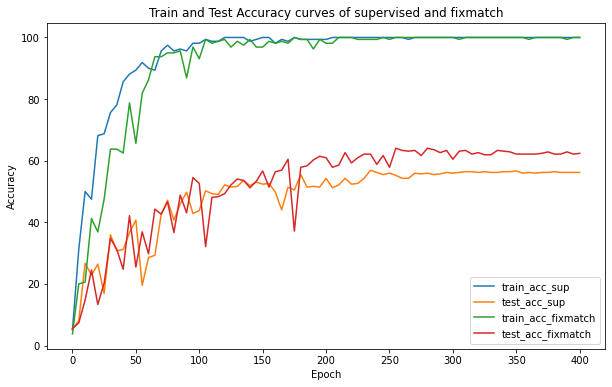

In [21]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(logs['epoch1'], logs['sup_train_acc'], label='train_acc_sup')
plt.plot(logs['epoch1'], logs['sup_test_acc'], label='test_acc_sup')
plt.plot(logs['epoch2'], logs['fixmatch_train_acc'], label='train_acc_fixmatch')
plt.plot(logs['epoch2'], logs['fixmatch_test_acc'], label='test_acc_fixmatch')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy curves of supervised and fixmatch')
plt.legend()
#plt.show()